In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Dataset Formats

We store data in sharded tar files. Sharded tar files are regular tar files with a few conventions:

- all files making up a training sample need to be physically consecutive in the tar file
- all files with a common basename are grouped into a single sample
- tar files can be split into sequentially numbered shards and are referred to by shell-style brace notation (e.g., `imagenet_train-{0000..0147}.tgz`

You can often just tar up dataset with `tar --sorted`. For more complex uses, there are command line tools and even special high performance servers.

In [2]:
!tar -ztvf testdata/imagenet-000000.tgz | head

-rw-r--r-- tmb/tmb           3 1969-12-31 16:00 10.cls
-rw-rw-r-- tmb/tmb       75442 2018-04-16 10:21 10.png
-rw-r--r-- tmb/tmb           9 1969-12-31 16:00 10.wnid
-rw-r--r-- tmb/tmb           4 1969-12-31 16:00 10.xml
-rw-r--r-- tmb/tmb           3 1969-12-31 16:00 12.cls
-rw-rw-r-- tmb/tmb       80108 2018-04-16 10:21 12.png
-rw-r--r-- tmb/tmb           9 1969-12-31 16:00 12.wnid
-rw-r--r-- tmb/tmb           4 1969-12-31 16:00 12.xml
-rw-r--r-- tmb/tmb           3 1969-12-31 16:00 13.cls
-rw-rw-r-- tmb/tmb      242280 2018-04-16 10:21 13.png
tar: write error


# Simple Dataset Loading

The `WebDataset` class is a reader for sharded tar files. By default, it reads files from a tar file, groups them into training samples by basename, applies standard file name extension conventions for decoding the images into tensors, and returns a dictionary mapping the extensions to decoded data.

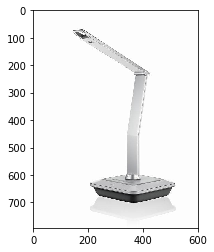

In [3]:
import webdataset.dataset as wds
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 47)
for sample in ds:
    image = sample["png"]
    imshow(image)
    break

Note how filenames are interpreted; consider a tar file containing the files:

- `dir/base.input.png`
- `dir/base.output.png`

This will be decoded into a Python sample containing two tensors:

    {
        "__key__": "dir/base",
        "input.png": ...decoded png image...,
        "output.png": ...decoded png image...
    }


Observe that everything from the first period (".") in the filename portion to the end becomes the key.

# Dataset Size

Because of the nature of tar archives, `WebDataset` cannot efficiently determine the size of a dataset; you can specify the actual size (or an approximation) as an integer during construction, or you can specify it as a JSON file that maps shards to the number of samples in that shard.

{"000000": {"num_samples": 47}}
47


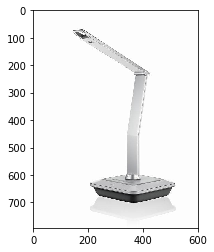

In [4]:
!cat testdata/imagenet-shards.json
import webdataset.dataset as wds
ds = wds.WebDataset("testdata/imagenet-000000.tgz", "testdata/imagenet-shards.json")
print(len(ds))
for sample in ds:
    image = sample["png"]
    imshow(image)
    break

# Field Selection

You can select fields by providing the `extensions=` argument. When provided, the iterator will yield tuples rather than dictionaries. This is convenient for training.

Since files are sometimes stored using different extensions, you can provide alternative names. Below, the first element of the tuple consists of any decoded file with an extension of "png" or "jpg", and the second element consists of the decoded ".cls" file.

(793, 600, 3) float32


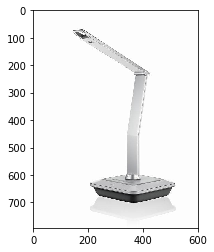

In [5]:
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 47,
                    extensions="png;jpg cls")
for sample in ds:
    image = sample[0]
    print(image.shape, image.dtype)
    imshow(image)
    break

# Decoders

One significant advantage of using tar files as a record sequential format is that there are a lot of conventions and tools for encoding and compressing binary data on file systems. This allows `WebDataset` to provide many useful defaults. For example, we can decode to 8-bit RGB images like this.

(793, 600, 3) uint8


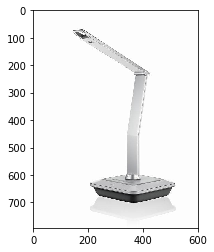

In [6]:
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 47, extensions="png;jpg cls", decoder="rgb8")
for sample in ds:
    image = sample[0]
    print(image.shape, image.dtype)
    imshow(image)
    break

To decode to PIL images, use `decoder="pil"`.

In [7]:
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 1000, decoder="pil")
for sample in ds:
    break
for k, v in sample.items():
    print(k, repr(v)[:60])

__key__ '10'
cls 304
png <PIL.Image.Image image mode=RGB size=600x793 at 0x7F42B6FE3E
wnid b'n04380533'
xml b'None'


Here is an example of grayscale decoding (the default decoder uses PIL/Pillow, and its image specs generally work as decoder strings).

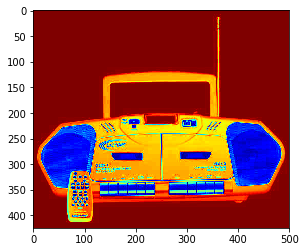

In [8]:
import webdataset.dataset as wds
ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-0050.tgz", 1000000,
                    extensions="jpg;png cls", decoder="l")
for sample in ds:
    image = sample[0]
    imshow(image, cmap=cm.jet)
    break

You can also get raw binary data file contents.

In [9]:
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 1000, decoder=None)
for sample in ds:
    break
for k, v in sample.items():
    print(k, repr(v)[:60])

__key__ '10'
cls b'304'
png b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x
wnid b'n04380533'
xml b'None'


# Custom Decoders

You may need to deal with data that there are no standard decoders built into `WebDataset` for. You can easily define your own handlers by defining a dictionary that maps file name extensions to decoding functions.

<PIL.Image.Image image mode=RGB size=128x128 at 0x7F42B6F0EAC8>


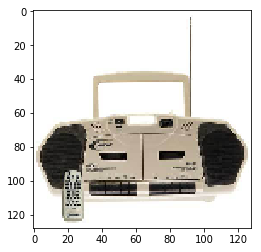

In [10]:
import PIL
import io
handlers = dict(
    jpg=lambda data: PIL.Image.open(io.BytesIO(data)).resize((128, 128)),
    cls=lambda data: int(data)
)
ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-0050.tgz", 1000000,
                    extensions="jpg;png cls", decoder=handlers)
for sample in ds:
    image = sample[0]
    print(image)
    imshow(image)
    break

If you need even more control, you can set the decoder to a function that just maps the sample to another sample.

In [11]:
def mydecoder(sample):
    return {k: len(v) for k, v in sample.items()}

ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-0050.tgz", 1000000,
                    extensions="jpg;png cls", decoder=mydecoder)
for sample in ds:
    image = sample[0]
    print(sample)
    break

(16444, 3)


# Accessing Web Servers / Object Stores

As the name suggests, `WebDataset` is intended for accessing training data on web servers, cloud storage, etc. To do this, you simply specify a URL as your dataset.

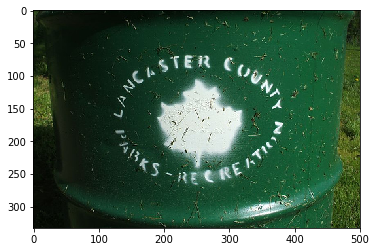

In [12]:
ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-0100.tgz", 60000,
                    extensions="jpg;png cls")
for sample in ds:
    image = sample[0]
    imshow(image)
    break

Larger datasets are broken up into shards and you refer to shards using shell-style brace notation. For example, the Imagenet dataset is customarily broken up into 147 shards, each of which is 1 Gbyte large. Shuffling and other operations can be carried out at the shard level and parallelized across many nodes.

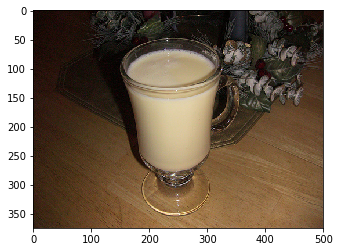

In [13]:
ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz", 1000000,
                    extensions="jpg;png cls", shuffle=True)
for sample in ds:
    image = sample[0]
    imshow(image)
    break

The default shard opener in `WebDataset` uses command line tools to access remote data; this provides asynchronous I/O and makes it easy to test things. It is probably the best choice for most users. But you can define custom openers that work any way you want: they can manipulate file names, use Python libraries instead of command line programs, etc.

0059


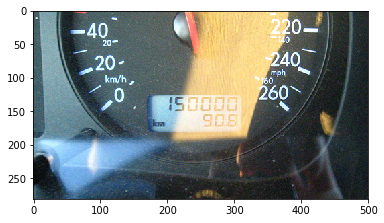

In [14]:
import sys, os, subprocess

def opener(url):
    print(url, file=sys.stderr)
    cmd = "curl -s 'http://storage.googleapis.com/lpr-imagenet/imagenet_train-{}.tgz'".format(url)
    return subprocess.Popen(cmd, bufsize=1000000, shell=True, stdout=subprocess.PIPE).stdout

ds = wds.WebDataset("{0000..0147}", 1000000,
                    extensions="jpg;png cls", shuffle=100, opener=opener)
for sample in ds:
    image = sample[0]
    imshow(image)
    break

Note that we used a `shuffle` option here. Any shuffle greater than 0 will shuffle the shards. Shuffles greater than one will additionally shuffle the samples in a buffer of size `shuffle`.

# Associating Extra Data

A common practice in DL datasets is to store large objects separately from smaller data, like class labels. `WebDataset` provides a simple way to associate these with one another. Here, we load the extra data from a JSON file, but it can be stored anywhere you like (sqlite, db, etc.)

In [15]:
import webdataset.dataset as wds
import simplejson

extra_data = simplejson.loads(open("testdata/imagenet-extra.json").read())
def associate(key):
    return dict(MY_EXTRA_DATA=extra_data[key])

ds = wds.WebDataset("testdata/imagenet-000000.tgz", 1000000, associate=associate)

for sample in ds:
    print(sample.keys())
    break

dict_keys(['__key__', 'cls', 'png', 'wnid', 'xml', 'MY_EXTRA_DATA'])


# Standard Torch Data Augmentation

Since `WebDataset` can decode images into PIL format, using it with existing `torchvision` augmentation pipelines is easy.

In [16]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],                    
                                 std=[0.229, 0.224, 0.225])                     
                                                                                
preproc = transforms.Compose([                                                  
    transforms.RandomResizedCrop(224),                                          
    transforms.RandomHorizontalFlip(),                                          
    transforms.ToTensor(),                                                      
    normalize,                                                                  
]) 

import webdataset.dataset as wds
ds = wds.WebDataset("http://storage.googleapis.com/lpr-imagenet/imagenet_train-{0000..0147}.tgz", 1000000,
                    decoder="pil",
                    extensions="jpg;png cls",
                    transforms=[preproc, lambda x: x-1, lambda x:x])
for sample in ds:
    break

image = sample[0]
print(type(image), image.dtype, image.size())
print(sample[1])

<class 'torch.Tensor'> torch.float32 torch.Size([3, 224, 224])
851


# Combination with Dataloader

`WebDataset` is a standard `IterableDataset` and can be used with the regular `DataLoader` 

In [17]:
import torch
dl = torch.utils.data.DataLoader(ds, batch_size=7)
for xs, ys in dl:
    print(xs.size(), ys.size())
    break

torch.Size([7, 3, 224, 224]) torch.Size([7])


Multi-worker dataloaders work as before.

In [18]:
import torch
dl = torch.utils.data.DataLoader(ds, batch_size=16, num_workers=4)
for xs, ys in dl:
    print(xs.size(), ys.size())
    break

torch.Size([16, 3, 224, 224]) torch.Size([16])


Note that parallelization happens at the level of shards, so you should have at least as many shards as workers.

In [19]:
import webdataset.dataset as wds
import torch
ds = wds.WebDataset("testdata/imagenet-000000.tgz", 1000, decoder=None)
dl = torch.utils.data.DataLoader(ds, num_workers=4)
for sample in dl:
    break

/home/tmb/exp/webdataset/webdataset/dataset.py:615: UserWarning: num_workers 4 > num_shards 1
  warnings.warn(f"num_workers {total} > num_shards {len(self.full_urls)}")
